Tuning opportunities
1. Configuration-Based Hyperparameter Tuning
2. Enhanced Data Augmentation
3. Improved Model Architecture
4. Advanced Callbacks
5. Transfer Learning (Often Best Results)
6. Class Imbalance Handling
7. Ensemble Methods
8. Systematic Tuning Strategy

Quick Start Guide:
For best results immediately: Set "backbone": "mobilenet" and "fine_tune": True
For faster training: Set "backbone": "custom_cnn" and "aug_level": "light"
For maximum accuracy: Enable ensemble with "use_ensemble": True
For experimentation: Uncomment Cell 17 to run systematic tuning

In [1]:
# =======================================================================
# Facial Emotion Recognition - Enhanced with 8 Tuning Improvements
# =======================================================================

import sys
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
from PIL import Image, UnidentifiedImageError
from pathlib import Path
from datetime import datetime

# TensorFlow and Keras
import tensorflow as tf
print(f"TensorFlow version: {tf.__version__}")
print(f"Python executable: {sys.executable}")

import seaborn as sns

# Deep learning libraries
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Flatten, Dropout, Dense, Input, 
    GlobalAveragePooling2D, Conv2D, 
    BatchNormalization, Activation, MaxPooling2D)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import (ModelCheckpoint, EarlyStopping, 
    ReduceLROnPlateau, LearningRateScheduler)
from tensorflow.keras.applications import MobileNetV2, EfficientNetB0

# Metrics
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support
from sklearn.utils.class_weight import compute_class_weight


print("=" * 70)
print("= importing libraries from huggingface for zeroGPU test")
print("=" * 70)



print("=" * 70)
print("✅ All libraries imported successfully")

2025-11-11 23:40:16.626045: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762904416.819571      48 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762904416.874978      48 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

TensorFlow version: 2.18.0
Python executable: /usr/bin/python3
= importing libraries from huggingface for zeroGPU test
✅ All libraries imported successfully


In [2]:
# =======================================================================
# Environment Detection
# =======================================================================

def is_on_kaggle():
    """Detect if running on Kaggle."""
    return os.path.exists('/kaggle/input')

def get_data_path():
    """Detect environment and return appropriate data path."""
    if is_on_kaggle():
        print("🌐 Running on Kaggle")
        import kagglehub
        image_path = kagglehub.dataset_download("jonathanoheix/face-expression-recognition-dataset")
        folder_path = os.path.join(image_path, "images")
    else:
        print("💻 Running on local machine")
        folder_path = "data/images/"
    
    return folder_path

folder_path = get_data_path()
print(f"Data folder path: {folder_path}")

🌐 Running on Kaggle
Data folder path: /kaggle/input/face-expression-recognition-dataset/images


In [3]:
# =======================================================================
# Enhanced Configuration with Tuning Options
# =======================================================================

cfg = {
    # Model Architecture
    "backbone": "custom_cnn",  # Options: "custom_cnn", "mobilenet", "efficientnet"
    
    # Image Parameters
    "picture_size": 48,  # Try: 64, 96 for more detail
    "color_mode": "grayscale",  # "grayscale" or "rgb" (rgb required for transfer learning)
    
    # Training Parameters
    "batch_size": 64,  # Reduced from 128 for better gradient estimates
    "epochs": 50,  # Increased from 30
    "learning_rate": 0.0001,  # Adjusted learning rate
    "dropout_rate": 0.25,  # Increased from 0.25
     
    # Dense layers
    "dense_units": [512],  # Added an extra dense layer (Improvement #6)
    
    # Data Augmentation (Improvement #2)
    "aug_level": "light",  # Options: "none", "light", "strong", "aggressive"
    
    # Advanced Training
    "precision": "mixed",  # "float32" or "mixed"
    "fine_tune": False,  # Enable fine-tuning for transfer learning
    "fine_tune_epochs": 0,
    
    # Optimizer
    "optimizer": "adam",  # Options: "adam", "adamw", "sgd"
    "weight_decay": 1e-4,  # For AdamW
    
    # Learning Rate Schedule
    "use_lr_schedule": True,  # Cosine annealing (Improvement #5)
    
    # Class Weights (Improvement #3)
    "use_class_weights": True,
    
    # Ensemble (Improvement #7)
    "use_ensemble": False,  # Set True to train multiple models
    "n_ensemble_models": 3,
    
    # Model Parameters
    "no_of_classes": 7,
}

print("Configuration loaded:")
for key, value in cfg.items():
    print(f"  {key}: {value}")

# Extract commonly used values
picture_size = cfg["picture_size"]
batch_size = cfg["batch_size"]
epochs = cfg["epochs"]
learning_rate = cfg["learning_rate"]
no_of_classes = cfg["no_of_classes"]
dropout_rate = cfg["dropout_rate"]
dense_units = cfg["dense_units"]

Configuration loaded:
  backbone: custom_cnn
  picture_size: 48
  color_mode: grayscale
  batch_size: 64
  epochs: 50
  learning_rate: 0.0001
  dropout_rate: 0.25
  dense_units: [512]
  aug_level: light
  precision: mixed
  fine_tune: False
  fine_tune_epochs: 0
  optimizer: adam
  weight_decay: 0.0001
  use_lr_schedule: True
  use_class_weights: True
  use_ensemble: False
  n_ensemble_models: 3
  no_of_classes: 7


In [4]:
# =======================================================================
# Mixed Precision Training
# =======================================================================

from tensorflow.keras import mixed_precision

if cfg.get("precision", "float32") == "mixed":
    mixed_precision.set_global_policy('mixed_float16')
    print("✅ Mixed precision training enabled - expect 2-3x speedup!")
else:
    mixed_precision.set_global_policy('float32')
    print("Using float32 precision")

✅ Mixed precision training enabled - expect 2-3x speedup!


In [5]:
# =======================================================================
# Enhanced Data Augmentation
# =======================================================================

aug_map = {
    "none": dict(rescale=1./255),
    
    "light": dict(
        rescale=1./255,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.2,
        horizontal_flip=True
    ),
    
    "strong": dict(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        zoom_range=0.2,
        brightness_range=[0.7, 1.3],
        horizontal_flip=True,
        fill_mode='nearest'
    ),
    
    "aggressive": dict(
        rescale=1./255,
        rotation_range=30,
        width_shift_range=0.25,
        height_shift_range=0.25,
        shear_range=0.2,
        zoom_range=0.25,
        brightness_range=[0.6, 1.4],
        horizontal_flip=True,
        channel_shift_range=0.2,
        fill_mode='nearest'
    )
}

# Create data generators
datagen_train = ImageDataGenerator(**aug_map[cfg["aug_level"]])
datagen_validation = ImageDataGenerator(**aug_map[cfg["aug_level"]])

print(f"✅ Using '{cfg['aug_level']}' augmentation level for training data")
print(f"✅ Using '{cfg['aug_level']}' augmentation level for validation data")

✅ Using 'light' augmentation level for training data
✅ Using 'light' augmentation level for validation data


In [6]:
# =======================================================================
# Load Training and Validation Data
# =======================================================================

# Determine color mode
color_mode = cfg["color_mode"]

# Create training set
train_set = datagen_train.flow_from_directory(
    os.path.join(folder_path, "train"),
    target_size=(picture_size, picture_size),
    color_mode=color_mode,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
)

# Create validation set
validation_set = datagen_validation.flow_from_directory(
    os.path.join(folder_path, "validation"),
    target_size=(picture_size, picture_size),
    color_mode=color_mode,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
)

print(f"\n✅ Data loaded successfully")
print (f"Colour Mode: {color_mode}")
print(f"Training samples: {train_set.n}")
print(f"Validation samples: {validation_set.n}")
print(f"Class indices: {train_set.class_indices}")

class_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.

✅ Data loaded successfully
Colour Mode: grayscale
Training samples: 28821
Validation samples: 7066
Class indices: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


In [7]:
# =======================================================================
# Calculate Class Weights for Imbalanced Data
# =======================================================================

class_weight_dict = None

if cfg.get("use_class_weights", False):
    class_weights = compute_class_weight(
        'balanced',
        classes=np.unique(train_set.classes),
        y=train_set.classes
    )
    class_weight_dict = dict(enumerate(class_weights))
    
    print("\n✅ Class weights calculated:")
    for emotion, weight in zip(class_labels, class_weights):
        print(f"  {emotion:>10}: {weight:.3f}")
else:
    print("\n⚠️  Class weights disabled")


✅ Class weights calculated:
       Angry: 1.031
     Disgust: 9.443
        Fear: 1.003
       Happy: 0.575
     Neutral: 0.826
         Sad: 0.834
    Surprise: 1.285


In [8]:
# =======================================================================
# Enhanced Model Building Functions
# =======================================================================


def build_improved_cnn(cfg):
    """Enhanced CNN with better architecture."""
    
    
    #color_mode = cfg.get("color_mode", "grayscale")
    channels = 1 if color_mode == "grayscale" else 3
    input_shape = (picture_size, picture_size, channels)
    
    print(f"Building Improved CNN with input shape: {input_shape}")
    
    model = Sequential()
    
    # Block 1 - Double Conv
    model.add(Conv2D(filters=32, 
                        kernel_size=(3, 3), 
                        padding='same', 
                        input_shape=input_shape,
                        name='conv2d_1'))

    # Block 2 - Double Conv
    model.add(Conv2D(filters=128, 
                      kernel_size=(3, 3), 
                      padding='same',
                      name='conv2d_2'))
    model.add(BatchNormalization(name='bn_2'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2),name='maxpool2d_2'))
    model.add(Dropout(dropout_rate,name='dropout_2'))
    
    # Block 3 - Double Conv
    model.add(Conv2D(filters=512, 
                      kernel_size=(5, 5), 
                      padding='same',
                      name='conv2d_3'))
    model.add(BatchNormalization(name='bn_3'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2),name='maxpool2d_3'))
    model.add(Dropout(dropout_rate,name='dropout_3'))
    
    # Block 4 - Double Conv
    model.add(Conv2D(filters=512, 
                      kernel_size=(3, 3), 
                      padding='same',
                      name='conv2d_4'))
    model.add(BatchNormalization(name='bn_4'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2),name='maxpool2d_4'))
    model.add(Dropout(dropout_rate,name='dropout_4'))

    
    # Block 5 - Double Conv
    model.add(Conv2D(filters=512, 
                      kernel_size=(3, 3), 
                      padding='same',
                      name='conv2d_5'))
    model.add(BatchNormalization(name='bn_5'))
    model.add(Activation('elu'))
    model.add(MaxPooling2D(pool_size=(2, 2),name='maxpool2d_5'))
    model.add(Dropout(dropout_rate,name='dropout_5'))
    
    """
        # Block 6 - Double Conv
    model.add(Conv2D(filters=512, 
                      kernel_size=(3, 3), 
                      padding='same',
                      name='conv2d_6'))
    model.add(BatchNormalization(name='bn_6'))
    model.add(Activation('elu'))
    model.add(MaxPooling2D(pool_size=(2, 2),name='maxpool2d_6'))
    model.add(Dropout(dropout_rate,name='dropout_6'))
    """
    
    
    # Output layer
    # Add dense layers before output
    model.add(Flatten())
    for idx, units in enumerate(dense_units):
        print(f"Adding dense layer with {units} units")
        model.add(Dense(units, name=f"dense_{idx+1}"))
        model.add(BatchNormalization(name=f"bn_dense_{idx+1}"))
        model.add(Activation('relu', name=f"act_dense_{idx+1}"))
        model.add(Dropout(dropout_rate, name=f"dropout_dense_{idx+1}"))
    model.add(Dense(no_of_classes, activation='softmax', dtype='float32', name='output_layer'))

   
    # Compile with optimizer choice
    optimizer_name = cfg.get("optimizer", "adam")
    if optimizer_name == "adam":
        opt = Adam(learning_rate=learning_rate)
    elif optimizer_name == "adamw":
        opt = tf.keras.optimizers.AdamW(
            learning_rate=learning_rate,
            weight_decay=cfg.get("weight_decay", 1e-4)
        )
    elif optimizer_name == "sgd":
        opt = tf.keras.optimizers.SGD(
            learning_rate=learning_rate,
            momentum=0.9,
            nesterov=True
        )
    
    model.compile(
        optimizer=opt,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    
    return model, None

# Build model based on configuration
print(f"\n{'='*70}")
print(f"Building model with '{cfg['backbone']}' backbone...")
print(f"{'='*70}")

if cfg["backbone"] == "custom_cnn":
    model, base_model = build_improved_cnn(cfg)
else:
    print ("removed mobilenet and efficientnet model code")

print(f"\n✅ Model built successfully")
model.summary()


Building model with 'custom_cnn' backbone...
Building Improved CNN with input shape: (48, 48, 1)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1762904456.016460      48 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1762904456.017214      48 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Adding dense layer with 512 units

✅ Model built successfully


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 48, 48, 128)    │        36,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_2 (BatchNormalization)       │ (None, 48, 48, 128)    │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 48, 48, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool2d_2 (MaxPooling2D)      │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 512)    │     1,638,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_3 (BatchNormalization)       │ (None, 24, 24, 512)    │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 24, 24, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool2d_3 (MaxPooling2D)      │ (None, 12, 12, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 12, 12, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_4 (BatchNormalization)       │ (None, 12, 12, 512)    │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 12, 12, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool2d_4 (MaxPooling2D)      │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_5 (BatchNormalization)       │ (None, 6, 6, 512)      │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool2d_5 (MaxPooling2D)      │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_dense_1 (BatchNormalization) │ (None, 512)            │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ act_dense_1 (Activation)        │ (None, 512)            │             

 Total params: 8,767,943 (33.45 MB)

 Trainable params: 8,763,591 (33.43 MB)

 Non-trainable params: 4,352 (17.00 KB)

In [9]:
# =======================================================================
# Advanced Training Callbacks
# =======================================================================

# Checkpoint
checkpoint = ModelCheckpoint('best_model.h5',
                                    monitor='val_accuracy',
                                    save_best_only=True,
                                    mode='max',
                                    verbose=1
                                )

# Early stopping with more patience
early_stopping = EarlyStopping(monitor='val_loss',
                                    patience=5,  # Increased from 10
                                    restore_best_weights=True,
                                    verbose=1
                                )

# Reduce learning rate on plateau
reduce_lr = ReduceLROnPlateau(
                    monitor='val_loss',
                    factor=0.5,
                    patience=2,  # Increased from 5
                    min_delta=0.0001,
                    verbose=1
                )

# Cosine annealing schedule (Improvement #5)
def cosine_annealing(epoch, lr):
    """Cosine annealing learning rate schedule."""
    import math
    # Fix:
    total_epochs = cfg.get("epochs", 50)
    initial_lr = cfg.get("learning_rate", 1e-4)
    min_lr = 1e-7
    
    if epoch < 5:  # Warmup phase
        return initial_lr * (epoch + 1) / 5
    else:
        progress = (epoch - 5) / (epochs - 5)
        return min_lr + (initial_lr - min_lr) * 0.5 * (1 + math.cos(math.pi * progress))

callbacks_list = [checkpoint, early_stopping, reduce_lr]

if cfg.get("use_lr_schedule", False):
    lr_scheduler = LearningRateScheduler(cosine_annealing, verbose=1)
    callbacks_list.append(lr_scheduler)
    print("✅ Using cosine annealing learning rate schedule")
else:
    callbacks_list.append(reduce_lr)
    print("✅ Using ReduceLROnPlateau")

print(f"✅ Callbacks configured: {len(callbacks_list)} callbacks")

✅ Using cosine annealing learning rate schedule
✅ Callbacks configured: 4 callbacks


In [10]:
# =======================================================================
# Model Training
# =======================================================================

print("\n" + "="*70)
print("🚀 STARTING TRAINING")
print("="*70)
print(f"Target: {epochs} epochs with early stopping")
print(f"Batch size: {batch_size}")
print(f"Learning rate: {learning_rate}")
print(f"Augmentation: {cfg['aug_level']}")
print(f"Backbone: {cfg['backbone']}")
print(f"Class weights: {'Enabled' if class_weight_dict else 'Disabled'}")
print("="*70)

history = model.fit(train_set,
                        epochs=epochs,
                        validation_data=validation_set,
                        callbacks=callbacks_list,
                        verbose=1,
                        batch_size=batch_size,
                        class_weight=class_weight_dict,  # Improvement #3
                        
                    )

print("\n✅ Initial training complete!")


🚀 STARTING TRAINING
Target: 50 epochs with early stopping
Batch size: 64
Learning rate: 0.0001
Augmentation: light
Backbone: custom_cnn
Class weights: Enabled


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: LearningRateScheduler setting learning rate to 2e-05.
Epoch 1/50


I0000 00:00:1762904464.360552     122 service.cc:148] XLA service 0x7e9044019200 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1762904464.361312     122 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1762904464.361334     122 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1762904465.241939     122 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-11-11 23:41:12.346485: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f16[64,24,24,128]{3,2,1,0}, u8[0]{0}) custom-call(f16[64,24,24,512]{3,2,1,0}, f16[512,5,5,128]{3,2,1,0}), window={size=5x5 pad=2_2x2_2}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$convBackwardInput", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_que

  2/451 ━━━━━━━━━━━━━━━━━━━━ 23s 52ms/step - accuracy: 0.0898 - loss: 2.0150   

I0000 00:00:1762904510.004785     122 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


335/451 ━━━━━━━━━━━━━━━━━━━━ 39s 338ms/step - accuracy: 0.1609 - loss: 2.2918

2025-11-11 23:43:48.558168: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng19{k2=2} for conv (f16[512,5,5,128]{3,2,1,0}, u8[0]{0}) custom-call(f16[21,24,24,128]{3,2,1,0}, f16[21,24,24,512]{3,2,1,0}), window={size=5x5 pad=2_2x2_2}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$convBackwardFilter", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2025-11-11 23:43:52.612425: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 5.054359697s
Trying algorithm eng19{k2=2} for conv (f16[512,5,5,128]{3,2,1,0}, u8[0]{0}) custom-call(f16[21,24,24,128]{3,2,1,0}, f16[21,24,24,512]{3,2,1,0}), window={size=5x5 pad=2_2x2_2}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$convBackwardFilter", backend_config={"cudnn_conv_backend_con

451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step - accuracy: 0.1641 - loss: 2.2776
Epoch 1: val_accuracy improved from -inf to 0.01571, saving model to best_model.h5


451/451 ━━━━━━━━━━━━━━━━━━━━ 261s 467ms/step - accuracy: 0.1641 - loss: 2.2775 - val_accuracy: 0.0157 - val_loss: 2.2906 - learning_rate: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 4e-05.
Epoch 2/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.1941 - loss: 2.1185
Epoch 2: val_accuracy improved from 0.01571 to 0.19884, saving model to best_model.h5


451/451 ━━━━━━━━━━━━━━━━━━━━ 48s 107ms/step - accuracy: 0.1941 - loss: 2.1185 - val_accuracy: 0.1988 - val_loss: 1.9478 - learning_rate: 4.0000e-05

Epoch 3: LearningRateScheduler setting learning rate to 6.000000000000001e-05.
Epoch 3/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.2114 - loss: 2.0252
Epoch 3: val_accuracy improved from 0.19884 to 0.24045, saving model to best_model.h5


451/451 ━━━━━━━━━━━━━━━━━━━━ 48s 105ms/step - accuracy: 0.2114 - loss: 2.0251 - val_accuracy: 0.2404 - val_loss: 1.8771 - learning_rate: 6.0000e-05

Epoch 4: LearningRateScheduler setting learning rate to 8e-05.
Epoch 4/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.2342 - loss: 1.9477
Epoch 4: val_accuracy improved from 0.24045 to 0.31418, saving model to best_model.h5


451/451 ━━━━━━━━━━━━━━━━━━━━ 47s 104ms/step - accuracy: 0.2342 - loss: 1.9476 - val_accuracy: 0.3142 - val_loss: 1.7734 - learning_rate: 8.0000e-05

Epoch 5: LearningRateScheduler setting learning rate to 0.0001.
Epoch 5/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.2649 - loss: 1.8815
Epoch 5: val_accuracy did not improve from 0.31418
451/451 ━━━━━━━━━━━━━━━━━━━━ 47s 105ms/step - accuracy: 0.2649 - loss: 1.8814 - val_accuracy: 0.2835 - val_loss: 1.8752 - learning_rate: 1.0000e-04

Epoch 6: LearningRateScheduler setting learning rate to 0.0001.
Epoch 6/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.2921 - loss: 1.8128
Epoch 6: val_accuracy improved from 0.31418 to 0.35126, saving model to best_model.h5


451/451 ━━━━━━━━━━━━━━━━━━━━ 49s 108ms/step - accuracy: 0.2921 - loss: 1.8127 - val_accuracy: 0.3513 - val_loss: 1.6661 - learning_rate: 1.0000e-04

Epoch 7: LearningRateScheduler setting learning rate to 9.987832431047822e-05.
Epoch 7/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.3186 - loss: 1.7191
Epoch 7: val_accuracy improved from 0.35126 to 0.36541, saving model to best_model.h5


451/451 ━━━━━━━━━━━━━━━━━━━━ 49s 108ms/step - accuracy: 0.3186 - loss: 1.7191 - val_accuracy: 0.3654 - val_loss: 1.6333 - learning_rate: 9.9878e-05

Epoch 8: LearningRateScheduler setting learning rate to 9.951389003364144e-05.
Epoch 8/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.3511 - loss: 1.6652
Epoch 8: val_accuracy improved from 0.36541 to 0.39796, saving model to best_model.h5


451/451 ━━━━━━━━━━━━━━━━━━━━ 48s 107ms/step - accuracy: 0.3511 - loss: 1.6652 - val_accuracy: 0.3980 - val_loss: 1.5783 - learning_rate: 9.9514e-05

Epoch 9: LearningRateScheduler setting learning rate to 9.89084726566536e-05.
Epoch 9/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.3707 - loss: 1.6089
Epoch 9: val_accuracy improved from 0.39796 to 0.41381, saving model to best_model.h5


451/451 ━━━━━━━━━━━━━━━━━━━━ 48s 107ms/step - accuracy: 0.3707 - loss: 1.6089 - val_accuracy: 0.4138 - val_loss: 1.5374 - learning_rate: 9.8908e-05

Epoch 10: LearningRateScheduler setting learning rate to 9.806502171211903e-05.
Epoch 10/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.3975 - loss: 1.5444
Epoch 10: val_accuracy did not improve from 0.41381
451/451 ━━━━━━━━━━━━━━━━━━━━ 47s 104ms/step - accuracy: 0.3975 - loss: 1.5445 - val_accuracy: 0.4029 - val_loss: 1.5893 - learning_rate: 9.8065e-05

Epoch 11: LearningRateScheduler setting learning rate to 9.698764640825613e-05.
Epoch 11/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.4090 - loss: 1.5123
Epoch 11: val_accuracy did not improve from 0.41381

Epoch 11: ReduceLROnPlateau reducing learning rate to 4.849382457905449e-05.
451/451 ━━━━━━━━━━━━━━━━━━━━ 46s 102ms/step - accuracy: 0.4091 - loss: 1.5122 - val_accuracy: 0.4053 - val_loss: 1.6095 - learning_rate: 4.8494e-05

Epoch 12: LearningRateScheduler set

451/451 ━━━━━━━━━━━━━━━━━━━━ 46s 102ms/step - accuracy: 0.4279 - loss: 1.4793 - val_accuracy: 0.4836 - val_loss: 1.3758 - learning_rate: 9.5682e-05

Epoch 13: LearningRateScheduler setting learning rate to 9.41532322633034e-05.
Epoch 13/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.4494 - loss: 1.4394
Epoch 13: val_accuracy did not improve from 0.48358
451/451 ━━━━━━━━━━━━━━━━━━━━ 46s 101ms/step - accuracy: 0.4494 - loss: 1.4394 - val_accuracy: 0.4549 - val_loss: 1.4361 - learning_rate: 9.4153e-05

Epoch 14: LearningRateScheduler setting learning rate to 9.241000240301348e-05.
Epoch 14/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.4566 - loss: 1.4056
Epoch 14: val_accuracy did not improve from 0.48358

Epoch 14: ReduceLROnPlateau reducing learning rate to 4.620500112650916e-05.
451/451 ━━━━━━━━━━━━━━━━━━━━ 45s 101ms/step - accuracy: 0.4566 - loss: 1.4056 - val_accuracy: 0.4605 - val_loss: 1.4325 - learning_rate: 4.6205e-05

Epoch 15: LearningRateScheduler sett

451/451 ━━━━━━━━━━━━━━━━━━━━ 47s 104ms/step - accuracy: 0.4713 - loss: 1.3638 - val_accuracy: 0.5024 - val_loss: 1.3187 - learning_rate: 9.0460e-05

Epoch 16: LearningRateScheduler setting learning rate to 8.831391993379295e-05.
Epoch 16/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.4769 - loss: 1.3235
Epoch 16: val_accuracy did not improve from 0.50241
451/451 ━━━━━━━━━━━━━━━━━━━━ 46s 103ms/step - accuracy: 0.4769 - loss: 1.3235 - val_accuracy: 0.5014 - val_loss: 1.3459 - learning_rate: 8.8314e-05

Epoch 17: LearningRateScheduler setting learning rate to 8.598102302691562e-05.
Epoch 17/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.4890 - loss: 1.3089
Epoch 17: val_accuracy did not improve from 0.50241

Epoch 17: ReduceLROnPlateau reducing learning rate to 4.299051215639338e-05.
451/451 ━━━━━━━━━━━━━━━━━━━━ 50s 112ms/step - accuracy: 0.4890 - loss: 1.3089 - val_accuracy: 0.4885 - val_loss: 1.3852 - learning_rate: 4.2991e-05

Epoch 18: LearningRateScheduler set

451/451 ━━━━━━━━━━━━━━━━━━━━ 48s 107ms/step - accuracy: 0.5015 - loss: 1.2860 - val_accuracy: 0.5345 - val_loss: 1.2296 - learning_rate: 8.0802e-05

Epoch 20: LearningRateScheduler setting learning rate to 7.798168552836381e-05.
Epoch 20/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.5066 - loss: 1.2687
Epoch 20: val_accuracy improved from 0.53453 to 0.54840, saving model to best_model.h5


451/451 ━━━━━━━━━━━━━━━━━━━━ 49s 110ms/step - accuracy: 0.5066 - loss: 1.2687 - val_accuracy: 0.5484 - val_loss: 1.1853 - learning_rate: 7.7982e-05

Epoch 21: LearningRateScheduler setting learning rate to 7.502500000000001e-05.
Epoch 21/50
450/451 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.5115 - loss: 1.2330
Epoch 21: val_accuracy did not improve from 0.54840
451/451 ━━━━━━━━━━━━━━━━━━━━ 49s 109ms/step - accuracy: 0.5115 - loss: 1.2330 - val_accuracy: 0.5304 - val_loss: 1.2436 - learning_rate: 7.5025e-05

Epoch 22: LearningRateScheduler setting learning rate to 7.194663878211442e-05.
Epoch 22/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.5221 - loss: 1.2222
Epoch 22: val_accuracy did not improve from 0.54840

Epoch 22: ReduceLROnPlateau reducing learning rate to 3.597332033677958e-05.
451/451 ━━━━━━━━━━━━━━━━━━━━ 49s 108ms/step - accuracy: 0.5221 - loss: 1.2222 - val_accuracy: 0.5048 - val_loss: 1.3385 - learning_rate: 3.5973e-05

Epoch 23: LearningRateScheduler set

451/451 ━━━━━━━━━━━━━━━━━━━━ 51s 112ms/step - accuracy: 0.5397 - loss: 1.1842 - val_accuracy: 0.5684 - val_loss: 1.1516 - learning_rate: 6.2134e-05

Epoch 26: LearningRateScheduler setting learning rate to 5.872372647446318e-05.
Epoch 26/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.5392 - loss: 1.1642
Epoch 26: val_accuracy did not improve from 0.56836
451/451 ━━━━━━━━━━━━━━━━━━━━ 48s 107ms/step - accuracy: 0.5392 - loss: 1.1642 - val_accuracy: 0.5187 - val_loss: 1.2686 - learning_rate: 5.8724e-05

Epoch 27: LearningRateScheduler setting learning rate to 5.52711967402193e-05.
Epoch 27/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.5528 - loss: 1.1389
Epoch 27: val_accuracy did not improve from 0.56836

Epoch 27: ReduceLROnPlateau reducing learning rate to 2.7635598598862998e-05.
451/451 ━━━━━━━━━━━━━━━━━━━━ 49s 108ms/step - accuracy: 0.5528 - loss: 1.1390 - val_accuracy: 0.5613 - val_loss: 1.1856 - learning_rate: 2.7636e-05

Epoch 28: LearningRateScheduler set

451/451 ━━━━━━━━━━━━━━━━━━━━ 47s 103ms/step - accuracy: 0.5557 - loss: 1.1206 - val_accuracy: 0.5692 - val_loss: 1.1655 - learning_rate: 5.1793e-05

Epoch 29: LearningRateScheduler setting learning rate to 4.8306770139710096e-05.
Epoch 29/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.5488 - loss: 1.1144
Epoch 29: val_accuracy did not improve from 0.56920

Epoch 29: ReduceLROnPlateau reducing learning rate to 2.4153385311365128e-05.
451/451 ━━━━━━━━━━━━━━━━━━━━ 46s 102ms/step - accuracy: 0.5488 - loss: 1.1144 - val_accuracy: 0.5483 - val_loss: 1.2250 - learning_rate: 2.4153e-05

Epoch 30: LearningRateScheduler setting learning rate to 4.4828803259780724e-05.
Epoch 30/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.5551 - loss: 1.1214
Epoch 30: val_accuracy improved from 0.56920 to 0.57671, saving model to best_model.h5


451/451 ━━━━━━━━━━━━━━━━━━━━ 47s 104ms/step - accuracy: 0.5551 - loss: 1.1214 - val_accuracy: 0.5767 - val_loss: 1.1240 - learning_rate: 4.4829e-05

Epoch 31: LearningRateScheduler setting learning rate to 4.1376273525536834e-05.
Epoch 31/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.5633 - loss: 1.1014
Epoch 31: val_accuracy did not improve from 0.57671
451/451 ━━━━━━━━━━━━━━━━━━━━ 46s 102ms/step - accuracy: 0.5632 - loss: 1.1014 - val_accuracy: 0.5509 - val_loss: 1.2190 - learning_rate: 4.1376e-05

Epoch 32: LearningRateScheduler setting learning rate to 3.796600131479661e-05.
Epoch 32/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.5714 - loss: 1.0914
Epoch 32: val_accuracy improved from 0.57671 to 0.59072, saving model to best_model.h5


451/451 ━━━━━━━━━━━━━━━━━━━━ 47s 104ms/step - accuracy: 0.5714 - loss: 1.0914 - val_accuracy: 0.5907 - val_loss: 1.1017 - learning_rate: 3.7966e-05

Epoch 33: LearningRateScheduler setting learning rate to 3.461460113097139e-05.
Epoch 33/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.5718 - loss: 1.0727
Epoch 33: val_accuracy did not improve from 0.59072
451/451 ━━━━━━━━━━━━━━━━━━━━ 46s 102ms/step - accuracy: 0.5718 - loss: 1.0727 - val_accuracy: 0.5681 - val_loss: 1.1592 - learning_rate: 3.4615e-05

Epoch 34: LearningRateScheduler setting learning rate to 3.1338400658875194e-05.
Epoch 34/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.5739 - loss: 1.0660
Epoch 34: val_accuracy did not improve from 0.59072

Epoch 34: ReduceLROnPlateau reducing learning rate to 1.5669200365664437e-05.
451/451 ━━━━━━━━━━━━━━━━━━━━ 47s 103ms/step - accuracy: 0.5739 - loss: 1.0660 - val_accuracy: 0.5730 - val_loss: 1.1421 - learning_rate: 1.5669e-05

Epoch 35: LearningRateScheduler s

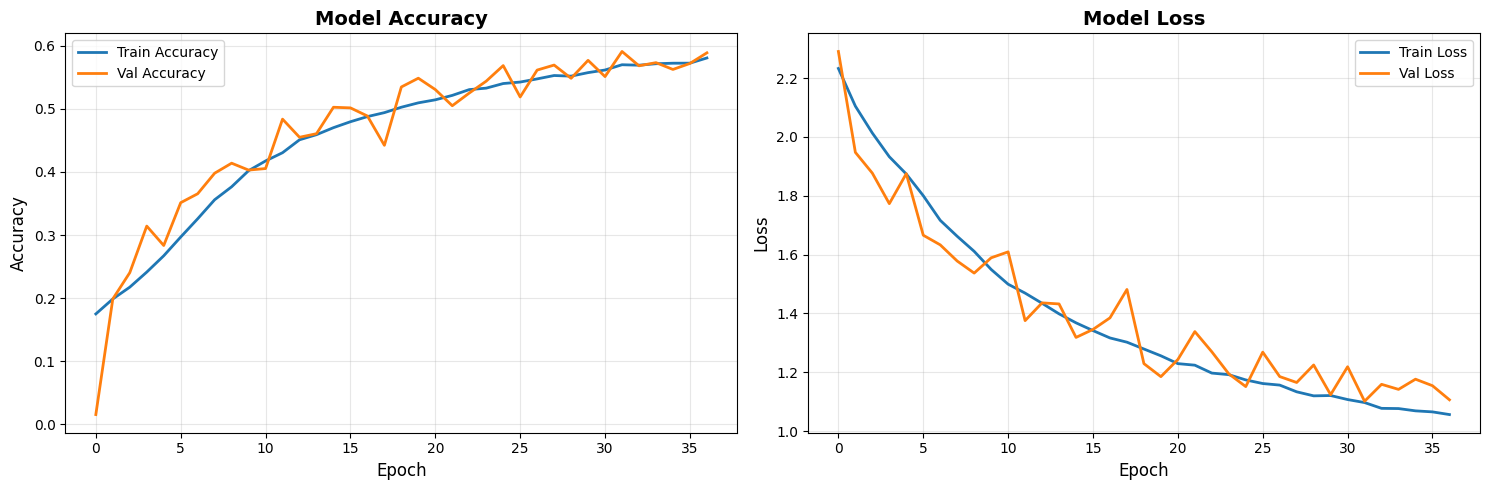


📊 FINAL EVALUATION
Training Accuracy:   0.6099 (60.99%)
Validation Accuracy: 0.5821 (58.21%)
Training Loss:       1.0414
Validation Loss:     1.1062


In [11]:
# =======================================================================
# Training History Visualization
# =======================================================================

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy plot
axes[0].plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
axes[0].plot(history.history['val_accuracy'], label='Val Accuracy', linewidth=2)
axes[0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Loss plot
axes[1].plot(history.history['loss'], label='Train Loss', linewidth=2)
axes[1].plot(history.history['val_loss'], label='Val Loss', linewidth=2)
axes[1].set_title('Model Loss', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
plt.show()

# Final evaluation
print("\n" + "="*70)
print("📊 FINAL EVALUATION")
print("="*70)
train_loss, train_acc = model.evaluate(train_set, verbose=0)
val_loss, val_acc = model.evaluate(validation_set, verbose=0)

print(f"Training Accuracy:   {train_acc:.4f} ({train_acc*100:.2f}%)")
print(f"Validation Accuracy: {val_acc:.4f} ({val_acc*100:.2f}%)")
print(f"Training Loss:       {train_loss:.4f}")
print(f"Validation Loss:     {val_loss:.4f}")
print("="*70)

In [12]:
# =======================================================================
# Detailed Performance Analysis
# =======================================================================

from keras.models import load_model

# Load best model
my_model = load_model('best_model.keras', compile=False)

# Get predictions
print("Generating predictions on validation set...")
validation_set.reset()
predictions = my_model.predict(validation_set, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = validation_set.classes

# Calculate metrics
accuracy = np.mean(predicted_classes == true_classes)
cm = confusion_matrix(true_classes, predicted_classes)

print(f"\n✅ Best Model Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

Generating predictions on validation set...
111/111 ━━━━━━━━━━━━━━━━━━━━ 12s 92ms/step

✅ Best Model Accuracy: 0.1480 (14.80%)


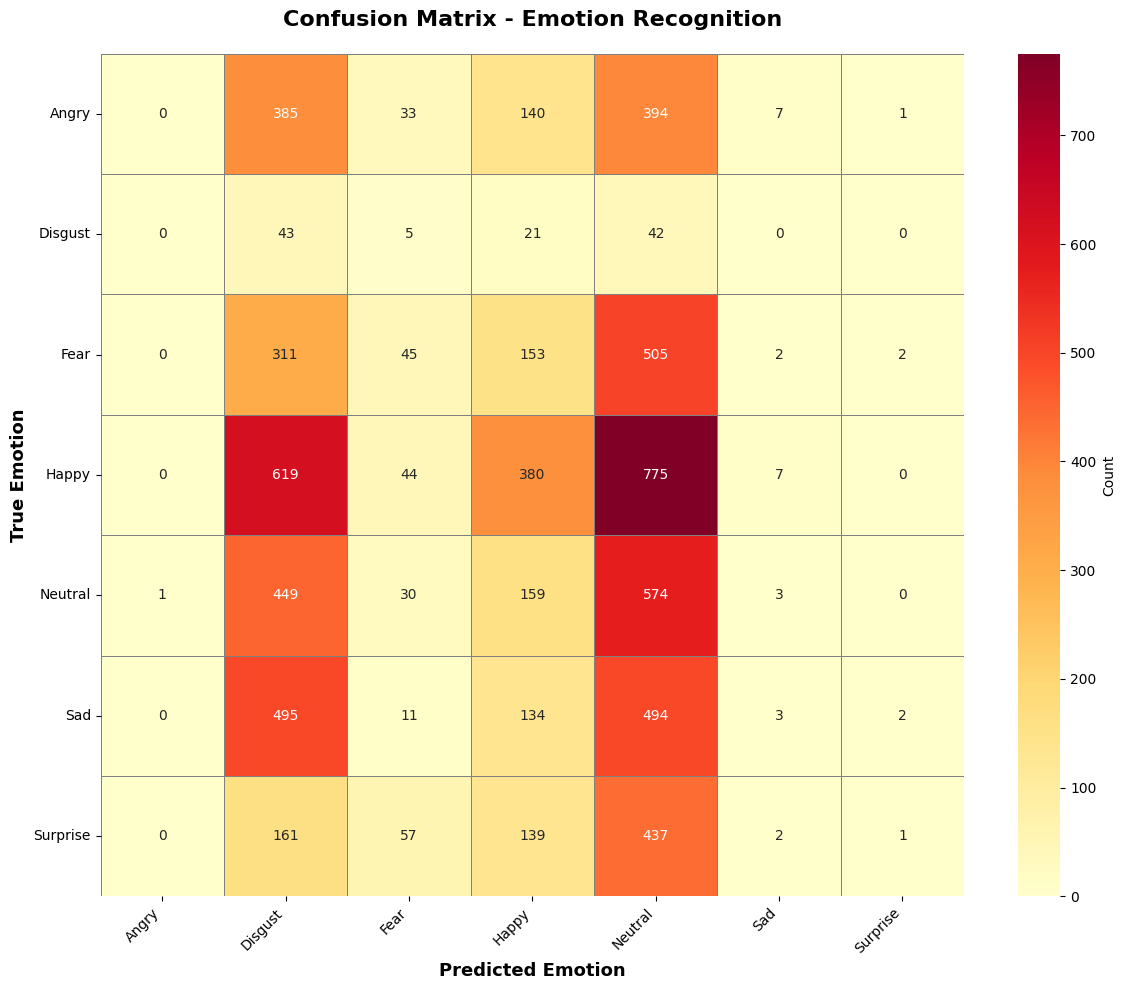

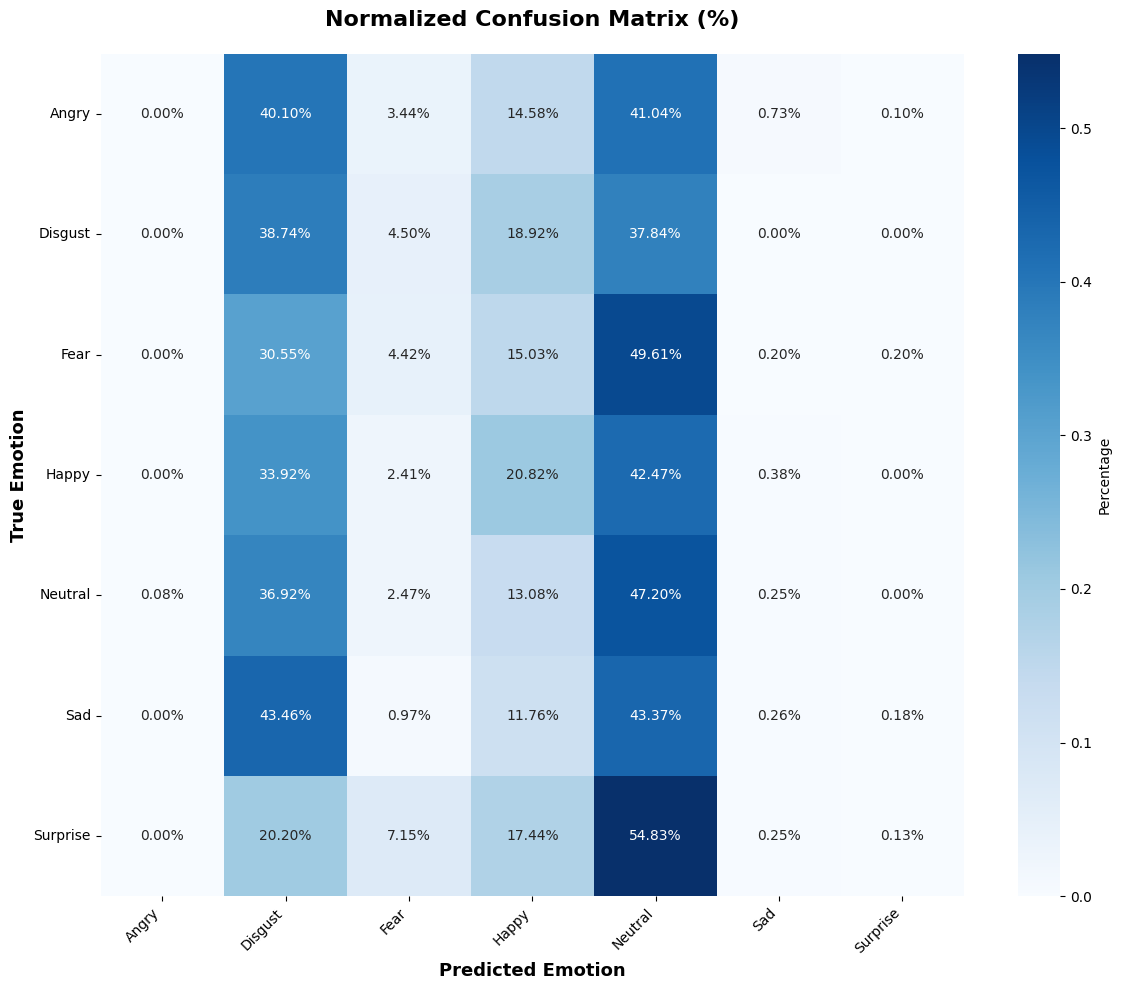


📈 DETAILED CLASSIFICATION METRICS
              precision    recall  f1-score   support

       Angry     0.0000    0.0000    0.0000       960
     Disgust     0.0175    0.3874    0.0334       111
        Fear     0.2000    0.0442    0.0724      1018
       Happy     0.3375    0.2082    0.2575      1825
     Neutral     0.1782    0.4720    0.2587      1216
         Sad     0.1250    0.0026    0.0052      1139
    Surprise     0.1667    0.0013    0.0025       797

    accuracy                         0.1480      7066
   macro avg     0.1464    0.1594    0.0900      7066
weighted avg     0.1859    0.1480    0.1231      7066



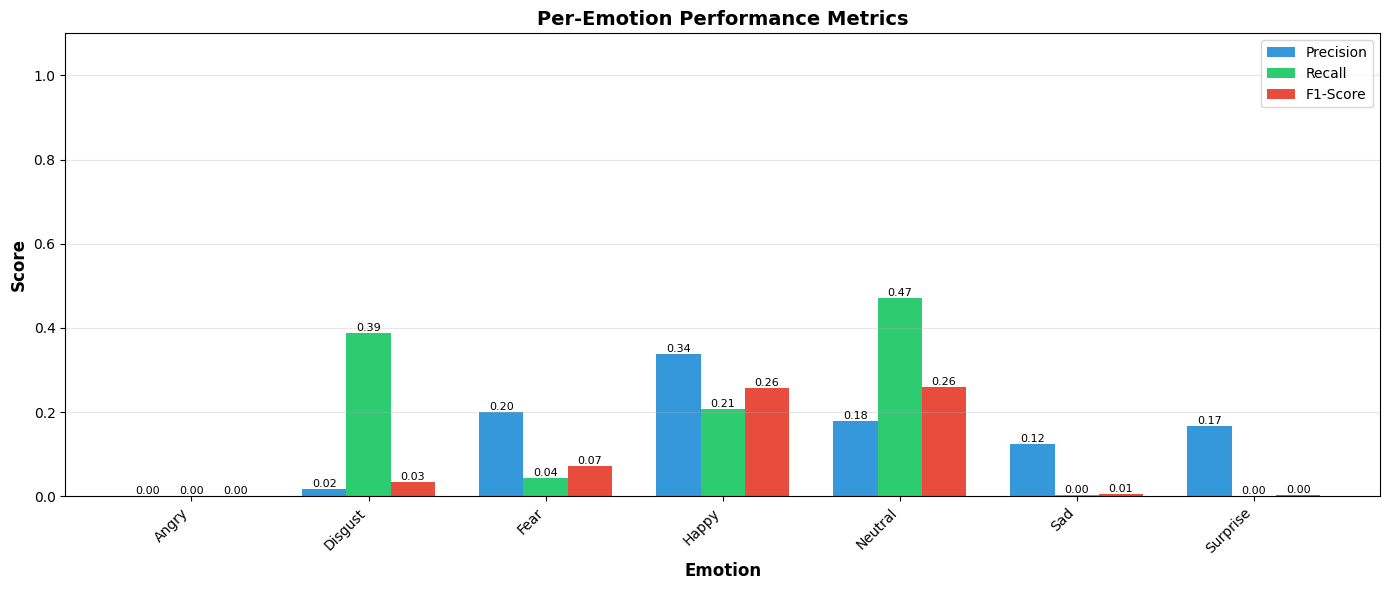


📊 PERFORMANCE SUMMARY TABLE
 Emotion Precision Recall F1-Score  Support
   Angry     0.00%  0.00%    0.00%      960
 Disgust     1.75% 38.74%    3.34%      111
    Fear    20.00%  4.42%    7.24%     1018
   Happy    33.75% 20.82%   25.75%     1825
 Neutral    17.82% 47.20%   25.87%     1216
     Sad    12.50%  0.26%    0.52%     1139
Surprise    16.67%  0.13%    0.25%      797

⚠️  TOP 5 MISCLASSIFICATION PAIRS
     Happy → Neutral    :  775 times
     Happy → Disgust    :  619 times
      Fear → Neutral    :  505 times
       Sad → Disgust    :  495 times
       Sad → Neutral    :  494 times


In [13]:
# =======================================================================
# Enhanced Performance Visualizations
# =======================================================================

# 1. Confusion Matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlOrRd',
            xticklabels=class_labels,
            yticklabels=class_labels,
            cbar_kws={'label': 'Count'},
            linewidths=0.5,
            linecolor='gray')
plt.title('Confusion Matrix - Emotion Recognition', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Predicted Emotion', fontsize=13, fontweight='bold')
plt.ylabel('True Emotion', fontsize=13, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# 2. Normalized Confusion Matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(12, 10))
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels,
            cbar_kws={'label': 'Percentage'})
plt.title('Normalized Confusion Matrix (%)', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Predicted Emotion', fontsize=13, fontweight='bold')
plt.ylabel('True Emotion', fontsize=13, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('confusion_matrix_normalized.png', dpi=300, bbox_inches='tight')
plt.show()

# 3. Classification Report
print("\n" + "="*70)
print("📈 DETAILED CLASSIFICATION METRICS")
print("="*70)
print(classification_report(true_classes, predicted_classes, 
                           target_names=class_labels,
                           digits=4))

# 4. Per-Class Metrics Bar Chart
precision, recall, f1, support = precision_recall_fscore_support(
    true_classes, predicted_classes, labels=range(7)
)

fig, ax = plt.subplots(figsize=(14, 6))
x = np.arange(len(class_labels))
width = 0.25

bars1 = ax.bar(x - width, precision, width, label='Precision', color='#3498db')
bars2 = ax.bar(x, recall, width, label='Recall', color='#2ecc71')
bars3 = ax.bar(x + width, f1, width, label='F1-Score', color='#e74c3c')

ax.set_xlabel('Emotion', fontsize=12, fontweight='bold')
ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title('Per-Emotion Performance Metrics', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(class_labels, rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)
ax.set_ylim([0, 1.1])

# Add value labels on bars
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}',
                ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.savefig('per_class_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

# 5. Summary Table
summary_df = pd.DataFrame({
    'Emotion': class_labels,
    'Precision': [f'{p:.2%}' for p in precision],
    'Recall': [f'{r:.2%}' for r in recall],
    'F1-Score': [f'{f:.2%}' for f in f1],
    'Support': support.astype(int)
})

print("\n" + "="*70)
print("📊 PERFORMANCE SUMMARY TABLE")
print("="*70)
print(summary_df.to_string(index=False))
print("="*70)

# 6. Misclassification Analysis
misclassified = cm.copy()
np.fill_diagonal(misclassified, 0)

top_confusions = []
for i in range(7):
    for j in range(7):
        if i != j:
            top_confusions.append((class_labels[i], class_labels[j], misclassified[i, j]))

top_confusions.sort(key=lambda x: x[2], reverse=True)

print("\n" + "="*70)
print("⚠️  TOP 5 MISCLASSIFICATION PAIRS")
print("="*70)
for true_label, pred_label, count in top_confusions[:5]:
    print(f"{true_label:>10} → {pred_label:<10} : {count:>4} times")
print("="*70)

In [14]:
# =======================================================================
# Save Model with Timestamp
# =======================================================================

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
model_name = f"emotion_recognition_{timestamp}.keras"

if is_on_kaggle():
    output_path = "/kaggle/working/"+timestamp+"/"
else:
    output_path = "outputs/"+timestamp+"/"
    
try:
    os.makedirs(output_path, exist_ok=True)
    full_path = Path(output_path) / model_name
    model.save(str(full_path))
except Exception as e:
    print(f"Error saving model: {e}")

print(f"\n💾 Model saved: {full_path}")
print(f"📊 Final Validation Accuracy: {val_acc:.4f} ({val_acc*100:.2f}%)")


💾 Model saved: /kaggle/working/20251112_001459/emotion_recognition_20251112_001459.keras
📊 Final Validation Accuracy: 0.5821 (58.21%)


In [15]:
# =======================================================================
# Ensemble Training (Optional)
# =======================================================================

if cfg.get("use_ensemble", False):
    print("\n" + "="*70)
    print("🎯 TRAINING ENSEMBLE MODELS")
    print("="*70)
    
    n_models = cfg.get("n_ensemble_models", 3)
    ensemble_models = []
    
    for i in range(n_models):
        print(f"\n{'='*70}")
        print(f"Training Ensemble Model {i+1}/{n_models}")
        print(f"{'='*70}")
        
        # Vary hyperparameters slightly
        cfg_copy = cfg.copy()
        cfg_copy["learning_rate"] = cfg["learning_rate"] * (0.8 + 0.4 * np.random.random())
        cfg_copy["dropout_rate"] = 0.3 + 0.2 * np.random.random()
        
        # Build model
        if cfg["backbone"] in ["mobilenet", "efficientnet"]:
            ensemble_model, _ = build_transfer_learning_model(cfg_copy)
        else:
            ensemble_model, _ = build_improved_cnn(cfg_copy)
        
        # Train
        history_ens = ensemble_model.fit(
            train_set,
            validation_data=validation_set,
            epochs=30,
            callbacks=[early_stopping, reduce_lr],
            class_weight=class_weight_dict,
            verbose=1
        )
        
        ensemble_models.append(ensemble_model)
        
        # Save
        ensemble_model.save(f"ensemble_model_{i+1}.keras")
    
    # Ensemble prediction
    print("\n" + "="*70)
    print("🎯 ENSEMBLE PREDICTION")
    print("="*70)
    
    validation_set.reset()
    ensemble_predictions = []
    
    for i, ens_model in enumerate(ensemble_models):
        print(f"Getting predictions from model {i+1}...")
        pred = ens_model.predict(validation_set, verbose=0)
        ensemble_predictions.append(pred)
    
    # Average predictions
    avg_predictions = np.mean(ensemble_predictions, axis=0)
    ensemble_predicted_classes = np.argmax(avg_predictions, axis=1)
    
    # Evaluate ensemble
    ensemble_accuracy = np.mean(ensemble_predicted_classes == true_classes)
    
    print(f"\n✅ Ensemble Accuracy: {ensemble_accuracy:.4f} ({ensemble_accuracy*100:.2f}%)")
    print(f"📈 Improvement over single model: {(ensemble_accuracy - accuracy)*100:.2f}%")
else:
    print("\n⚠️  Ensemble training disabled (set 'use_ensemble': True to enable)")


⚠️  Ensemble training disabled (set 'use_ensemble': True to enable)


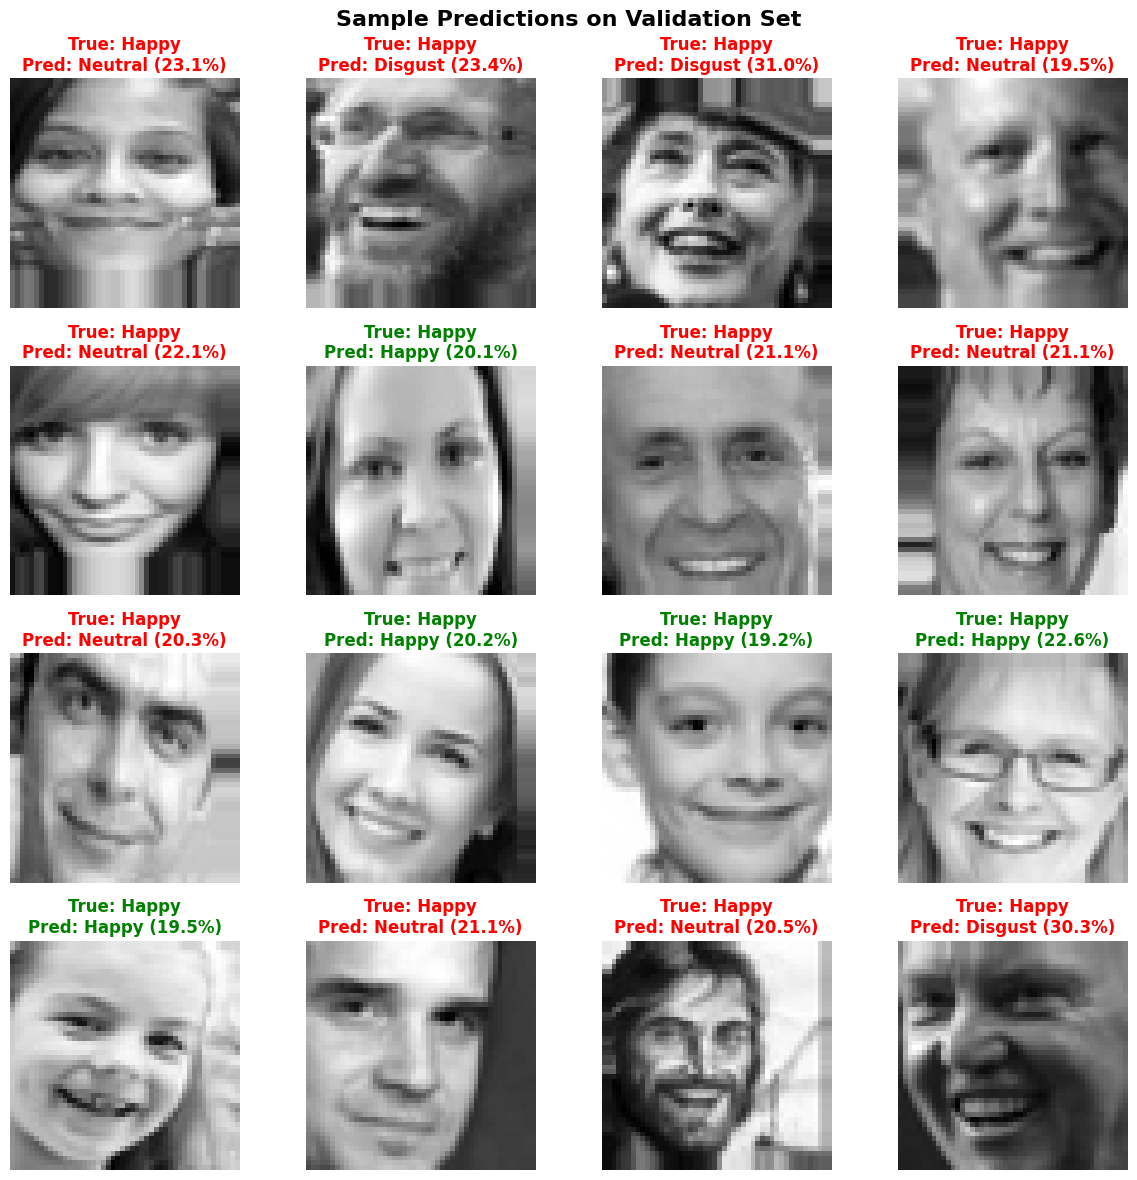

In [19]:
# =======================================================================
# Sample Predictions Visualization
# =======================================================================
import random

# Get a random batch from validation set
random_batch_idx = random.randint(0, len(validation_set) - 1)
sample_images, sample_labels = validation_set[random_batch_idx]

# Predict
sample_preds = my_model.predict(sample_images, verbose=0)
sample_pred_classes = np.argmax(sample_preds, axis=1)
sample_true_classes = np.argmax(sample_labels, axis=1)

# Randomly select 16 indices from the batch
num_samples = min(16, len(sample_images))
random_indices = random.sample(range(len(sample_images)), num_samples)

# Visualize predictions
fig, axes = plt.subplots(4, 4, figsize=(12, 12))
axes = axes.ravel()

for i, idx in enumerate(random_indices):
    axes[i].imshow(sample_images[idx].squeeze(), cmap='gray')
    
    true_label = class_labels[sample_true_classes[idx]]
    pred_label = class_labels[sample_pred_classes[idx]]
    confidence = sample_preds[idx][sample_pred_classes[idx]] * 100

    # Color: green if correct, red if wrong
    color = 'green' if sample_true_classes[idx] == sample_pred_classes[idx] else 'red'
    
    axes[i].set_title(f'True: {true_label}\nPred: {pred_label} ({confidence:.1f}%)', 
                     color=color, fontweight='bold')
    axes[i].axis('off')

plt.suptitle('Sample Predictions on Validation Set', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('sample_predictions.png', dpi=300, bbox_inches='tight')
plt.show()

In [17]:
model.saved = True